In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
import heapq
import json
import math
import time

import imageio
import loading
import tqdm

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import svm

In [54]:
"""DEFINE CONSTANTS HERE"""

DATA_PATH           = '../data'
VISUALIZATION_PATH  = '../visualization'

MISSING_VALUE       = '<NONE>'       # Used for the 'neighborhood' and 'city' attributes.
DEFAULT_NEI_P       = 0.2            # Default percentile of neighborhoods to keep.
DEFAULT_CITY_P      = 0.1            # Default percentile of cities to keep.
DEFAULT_ATT_P       = 1.0            # Default percentile of attributes to keep.
DEFAULT_CAT_P       = 0.5            # Default percentile of categories to keep.
DEFAULT_HRS_P       = 1.0            # Default percentile of hours to keep.

TIME_GRANULARITY    = 1              # Granularity (ticks/hr) of time calculations, factor of 60. 

SLICE_BY            = ['Restaurants']

In [4]:
"""Loads the json file of the given dataset name."""
def load(name):
  start = time.time()
  data = loading.read_df_from_json('%s/%s.json' % (DATA_PATH, name))
  print 'time to load \'%s\': %.3fs' % (name, time.time() - start)
  return data

In [5]:
"""Cleans the business dataset."""
def clean_business(business):
  print 'Replacing %s with %s.' % (u'Montréal', u'Montreal')
  business['city'].replace(to_replace=u'Montréal', 
                           value=u'Montreal',
                           inplace=True)

In [6]:
"""Plots all businesses on the world map for visualization purposes."""
def plot_business(business):
  points = business[['latitude', 'longitude']]

  img = imageio.imread(VISUALIZATION_PATH + '/raw_map.jpg').astype('int64')
  img = img / 4               # Dim map.
  img = img[8:-8,8:-8,:]      # Clip borders.
  H, W, _ = img.shape
  
  scalar = 10                 # Amount to add to each channel.
  delta = np.zeros((H, W), dtype='int64')
  
  def get_xy(latitude, longitude):
    x = (W - 1) * (180.0 + longitude) / 360.0
    y = (H - 1) * (90.0 - latitude) / 180.0
    return int(x), int(y)

  for row in points.itertuples():
    latitude, longitude = row.latitude, row.longitude
    if not math.isnan(latitude) and not math.isnan(longitude):
      x, y = get_xy(latitude, longitude)
      delta[y,x] += scalar

  img += np.expand_dims(delta, axis=-1).repeat(3, axis=-1)
  img = img.clip(0, 255).astype('uint8')
  
  return img

In [7]:
"""Returns the count_dict as a sorted list."""
def to_list(count_dict):
  return sorted([(k, count_dict[k]) for k in count_dict], key=lambda v: v[1])

In [8]:
"""Converts a dict of counts (key, int) into a list of top features.

   Takes either top N (int) features, or top PERCENTILE (float) by occurrence.

   Example usage:
     top_features(count_dict, 0.1)                  # Returns top 10% of elements.
     top_features(count_dict, top_n=5)              # Returns top 5 elements.
"""
def top_features(count_dict, percentile=None, n=None, verbose=True):
  if n is None:
    if percentile is None:
      raise Exception
    n = int(percentile * len(count_dict))

  l = heapq.nlargest(n, count_dict, key=lambda k: count_dict[k])
  
  if verbose:
    percentage = 0.0 if not len(count_dict) else 100.0 * n / len(count_dict)
    params = (n, len(count_dict), percentage, 0 if not l else count_dict[l[-1]])
    print 'Took %d elements out of %d (%2.1f%%). Cutoff was >= %d.' % params
    
  return l

In [9]:
"""Methods for converting a tuple from itertuples() to a feature list."""

# Return neighborhood concatenated with city, or MISSING_VALUE if empty. 
def get_neighborhood(tup):
  assert type(tup.neighborhood) is unicode
  return [tup.neighborhood + '/' + tup.city if tup.neighborhood else MISSING_VALUE]

# Return city, or MISSING_VALUE if empty.
def get_city(tup):
  assert type(tup.city) is unicode
  return [tup.city if tup.city else MISSING_VALUE]

# Recursively process attributes dict to get indicators for all attributes.
def get_attributes(tup):
  def _recurse(attributes, prefix):
    assert type(attributes) is dict
    l = []
    for k, v in attributes.items():
      if type(v) is bool:
        l.append(prefix + '/' + k)
      elif type(v) is unicode:
        l.append(prefix + '/' + k + '/' + v)
      elif type(v) is int:
        l.append(prefix + '/' + k + '/' + str(v))
      elif type(v) is dict:
        l += _recurse(attributes[k], prefix=k)
      else:
        assert False  # Invalid type in attributes.
    return l
  return _recurse(tup.attributes, prefix='')

# Return categories.
def get_categories(tup):
  assert type(tup.categories) is list
  return tup.categories

"""Helper methods for get_hours(), which determines which ticks of time the business is open.
   Each tick of time corresponds to an index in [0, _max_ticks()).

   In _time_to_dt_index, ROUND_UP determines what happens when the time falls
   in between ticks. By default, the time is rounded up.
"""
# An ordering of the days of the week, and a map from str --> index
_day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
_day_index = {d:i for i, d in enumerate(_day_order)}

# Maximum number of ticks
def _max_ticks():
  return 7 * 24 * TIME_GRANULARITY

# Given day of the week and time, returns the corresponding tick in [0, _max_ticks()).
def _time_to_dt_index(day, time, round_up=True):
  [hour, minutes] = time.split(':')
  hour_index = int(hour) * TIME_GRANULARITY
  min_index  = int(minutes) / (60 / TIME_GRANULARITY)
  if round_up and int(minutes) % (60 / TIME_GRANULARITY) > 0:
    min_index += 1
  return _day_index[day] * 24 * TIME_GRANULARITY + hour_index + min_index

# Cache the string corresponding to each tick of time.
_timestr_cache = ['%s/%02d:%02d' % (_day_order[day], hour, min_index * 60 / TIME_GRANULARITY)
                  for day in range(0, 7)
                  for hour in range(0, 24)
                  for min_index in range(0, TIME_GRANULARITY)]

def get_hours(tup):
  assert type(tup.hours) is dict
  l = []
  for day, hours in tup.hours.items():
    open_time, close_time = hours.split('-')
    open_index = _time_to_dt_index(day, open_time)
    close_index = _time_to_dt_index(day, close_time)

    assert 0 <= open_index and close_index <= _max_ticks()
    
    # Handle the case where close_index is for the following day.
    if close_index <= open_index:
      close_index += 24 * TIME_GRANULARITY
    
    # Append the slice of the _time_str_cache, handling wrap-around appropriately.
    l += _timestr_cache[open_index:min(close_index, _max_ticks())]
    if close_index > _max_ticks():
      l += _timestr_cache[0:close_index - _max_ticks()]
      
  return l

# Function to retrieve all features of a given row tuple.
all_fns = [get_neighborhood, get_city, get_attributes, get_categories, get_hours]
def get_all_features(tup):
  all_features = set([])
  for fn in all_fns:
    all_features |= set(fn(tup))
  return all_features

# Returns the value to regress on for the row tuple.
def get_target(tup):
  return float(tup.stars)

In [51]:
"""Get the features that we will use for 
   neighborhoods, cities, attributes, categories.

   By default, take:
     TOP 20% OF neighborhoods
     TOP 10% OF cities
         ALL OF attributes
     TOP 50% OF categories
         ALL OF hours
   
   Returns a length 6 tuple:
     (nei_set, city_set, att_set, cat_set, hours_set, debug_vals)
"""
def get_feature_sets(business, slice_by=[],
                     percentiles=[DEFAULT_NEI_P, DEFAULT_CITY_P, DEFAULT_ATT_P, 
                                  DEFAULT_CAT_P, DEFAULT_HRS_P]):
  def has_required_features(all_features):
    all_features_set = set([])
    for features in all_features:
      all_features_set |= set(features)
    for f in slice_by:
      if f not in all_features_set:
        return False
    return True
  
  fn_counts_percentile = zip(all_fns, [defaultdict(int) for _ in range(len(all_fns))], percentiles)

  for tup in tqdm.tqdm(business.itertuples()):
    all_features = [fn(tup) for fn, _, _ in fn_counts_percentile]
    if not has_required_features(all_features):
      continue
    for features, (_, counts, _) in zip(all_features, fn_counts_percentile):
      for f in features:
        counts[f] += 1

  debug_val = [(fn.__name__, to_list(counts)) for fn, counts, _ in fn_counts_percentile]
  
  return [top_features(counts, percentile) for fn, counts, percentile in fn_counts_percentile], debug_val

In [11]:
"""Gets a mapping from feature name to feature index and vice versa."""
def get_feature_maps(feature_sets, start_index=0):  
  # Assert that there are no overlapping names.
  union = set([])
  for s in feature_sets:
    union |= set(s)
  assert len(union) == sum([len(s) for s in feature_sets])

  name_to_index, index_to_name = {}, {}
  for i, feature in enumerate(union):
    name_to_index[feature] = start_index + i
    index_to_name[start_index + i] = feature

  return name_to_index, index_to_name

In [91]:
def slice_by_feature(x, y, name_to_index, feature_name):
  if feature_name not in name_to_index:
    print 'Feature %s not found.' % feature_name
    return x, y
  feature_index = name_to_index[feature_name]
  indices = np.where(x[:,feature_index] == 1)
  return x[indices], y[indices]

def slice_by_features(x, y, name_to_index, slice_by):
  for feature_name in slice_by:
    x, y = slice_by_feature(x, y, name_to_index, feature_name)
  return x, y

In [57]:
"""Creates a list of data points for multivariate linear regression."""
def get_training_data(business, name_to_index, slice_by=[]):
  x = np.zeros((business.shape[0], len(name_to_index)), dtype='float32')
  y = np.zeros(business.shape[0], dtype='float32')
  
  for i, tup in tqdm.tqdm(enumerate(business.itertuples())):
    all_features = get_all_features(tup)
    for f in all_features:
      if f in name_to_index:
        x[i,name_to_index[f]] = 1
    y[i] = get_target(tup)
  
  return slice_by_features(x, y, name_to_index, slice_by)

Run business regression.

NOT USABLE:
- business_id
- name

PROBABLY NOT USABLE:
- latitude
- longitude
- postal code
- address
- is_open
- review_count
- state

REGRESS ON:
- stars  (1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5)

FEATURES:
- neighborhood/city  --> indicators (~20%)
- city               --> indicators (~10%)
- attributes         --> indicators (process types differently, each has a separate indicator)
- categories         --> indicators (~50%)
- hours              --> indicators for every hour/half hour/quarter of the hour

In [13]:
business = load('business')
clean_business(business)

time to load 'business': 10.078s
Replacing Montréal with Montreal.


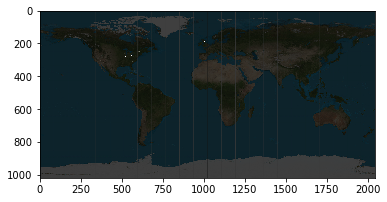

In [14]:
# img = plot_business(business)
# plt.imshow(img)
# plt.show()
# imageio.imsave(VISUALIZATION_PATH + '/business_map.jpg', img)

In [87]:
SLICE_BY = ['Restaurants', 'Las Vegas']

feature_sets, debug_val = get_feature_sets(business, slice_by=SLICE_BY, 
                                           percentiles=[0, 0, 0.7, 0.15, 0.0])

156639it [00:12, 12402.52it/s]

Took 0 elements out of 17 (0.0%). Cutoff was >= 0.
Took 0 elements out of 1 (0.0%). Cutoff was >= 0.
Took 68 elements out of 98 (69.4%). Cutoff was >= 210.
Took 55 elements out of 367 (15.0%). Cutoff was >= 67.
Took 0 elements out of 168 (0.0%). Cutoff was >= 0.


In [88]:
feature_maps = get_feature_maps(feature_sets)
name_to_index, index_to_name = feature_maps  

In [92]:
x, y = get_training_data(business, name_to_index, slice_by=SLICE_BY)

156639it [00:13, 11398.35it/s]

Feature Las Vegas not found.


In [95]:
print 'Slicing by:', SLICE_BY
print 'Samples in slice:', len(x)
print

reg = linear_model.Ridge(alpha=0.5)
reg.fit(x, y)

print 'Intercept =', reg.intercept_
print

N = 20
coefs = [(index_to_name[i], c) for i, c in enumerate(reg.coef_)]
for n, c in heapq.nlargest(N, coefs, key=lambda v: v[1]):
  print n, c
print '...'
for n, c in reversed(heapq.nsmallest(N, coefs, key=lambda v: v[1])):
  print n, c
print

y_hat = reg.predict(x)
print mean_squared_error(y, y_hat)

Slicing by: ['Restaurants', 'Las Vegas']
Samples in slice: 51613

Intercept = 3.42863002133

Food Trucks 0.503721189911
Vegan 0.310249831585
Latin American 0.304698307876
Specialty Food 0.19723425462
Hawaiian 0.193233022244
Caterers 0.181126202125
/NoiseLevel/quiet 0.178869492326
/BusinessAcceptsBitcoin 0.165457197119
Hot Dogs 0.161799877354
Cafes 0.159833528903
Mediterranean 0.155404954686
Cocktail Bars 0.141440857677
/BikeParking 0.141183978371
/DogsAllowed 0.137219530013
Vegetarian 0.122983135473
/NoiseLevel/average 0.119932418755
Delis 0.106269375438
Wine Bars 0.10616741121
Juice Bars & Smoothies 0.100565445163
BusinessParking/valet 0.0973292784071
...
Diners -0.0269120666587
Lounges -0.0382160426827
/Caters -0.0390381064039
/NoiseLevel/loud -0.0536582248842
/RestaurantsPriceRange2/2 -0.0561542784755
/HasTV -0.0587589697849
Steakhouses -0.0685345834929
/RestaurantsTableService -0.0776730160486
/RestaurantsAttire/casual -0.0974333183548
American (Traditional) -0.107027958408
Pizza -

In [75]:
f = 'Poke'
print np.sum(x[:,name_to_index[f]])
print np.mean(y[np.where(x[:,name_to_index[f]] == 1)])

61.0
4.2541


In [17]:
"""Splits list of data points 80/20 for training versus test."""
def training_test_split(x, y):
    indices = np.random.permutation(x.shape[0])
    cutoff = int(.8 * x.shape[0])
    training_idx, test_idx = indices[:cutoff], indices[cutoff+1:]
    x_train, x_test = x[training_idx,:], x[test_idx,:]
    y_train, y_test = y[training_idx], y[test_idx]
    return x_train, y_train, x_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = training_test_split(x, y)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [ ]:
rmse = mean_squared_error(y_test, y_pred)
print "RMSE For Test Set ", rmse